In [1]:
from griblib import HARMONIE
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS

from scipy import ndimage
import pandas as pd
import glob

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': 10.0, 'max': 25.0}
wind_lim = {'min': 2.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 15.0}
P_lim = {'min': 1011, 'max': 1017.0 }
mld_lim = {'min': 0.0, 'max': 5.0e3 }
tke_lim = {'min': 0.1, 'max': 5.0}
rain_lim = {'min': 1.0e-3, 'max': 100.0 }
ptke_lim = {'min': 0.0, 'max': 5.0}

# interpolation point
lon = 4.0
lat = 52.0

In [5]:
import pandas as pd
# Cabauw and De Bilt

df = pd.DataFrame(
    {'Site': ['NL.CIA', 'NL.DBNI', 'NL.DIA', 'NL.IS311', 'NL.EXL'],
     'Location': ['Cabauw', 'De Bilt', 'Deelen', 'Dwingeloo', 'Exloo'],
     'Latitude': [51.968840, 52.098870, 52.060110, 52.811785, 52.906795],
     'Longitude': [4.927930, 5.175890, 5.887300, 6.394668, 6.865549]
    })
df

Site   Location   Latitude  Longitude
0    NL.CIA     Cabauw  51.968840   4.927930
1   NL.DBNI    De Bilt  52.098870   5.175890
2    NL.DIA     Deelen  52.060110   5.887300
3  NL.IS311  Dwingeloo  52.811785   6.394668
4    NL.EXL      Exloo  52.906795   6.865549

In [6]:
#fid_grib = 'cy36/20170529_00/HARM_N25_201705290000_00300_GB'
fid_grib = 'cy36/20170529_03/HARM_N25_201705290300_00100_GB'
#fid_grib = 'cy36/20170529_06/HARM_N25_201705290600_00200_GB'
#fid_grib = 'cy38/20170529_00/HA38_N25_201705290000_00400_GB'
fid_profile = 'harm20170529-04.dat'
fid_provinces = '/Users/assink/infrasound/network/maps/NL/GMT/Provinciegrenzen_2018-shp/Provinciegrenzen_2018.shp'

In [7]:
prov2018 = list(shpreader.Reader(fid_provinces).geometries())

In [8]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'range-azimuth'
path_params['start'] = dict(lat=51.0, lon=0.0)
# path_params['end'] = dict(lat=54.0, lon=9.0)
path_params['range'] = 700.0e3
path_params['azimuth'] = 60.0
dr = 1.0e3

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)
path_params['end'] = dict(lat=lats[-1], lon=lons[-1])

In [9]:
my_atmos = HARMONIE(cycle='36')

In [10]:
def read_HARMONIE_set_one(self, fid_grid):
    request = [
        {'level_type': 'hybrid', 'var_list': ['u', 'v', 'pdep', 'tke']},
        {'level_type': 'heightAboveSea'},
        {'level_type': 'heightAboveGround', 'var_list': ['ugst', 'vgst', 'mld']}
    ]

    if self.cycle == 36:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['tp']})
    else:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['rain'], 'step_type': 'instant' })

    ds = self.read_grib(fid_grib, request, compat='override')
    return ds

def read_HARMONIE_set_two(self, fid_grid):
    request = [
        {'level_type': 'heightAboveGround', 'var_list': ['pres', 't'], 'level': 0}
    ]

    ds = self.read_grib(fid_grib, request, verbose=False, compat='override')
    return ds

In [11]:
def read_HARMONIE(self, fid_grib):
    # Read data
    ds = read_HARMONIE_set_one(self, fid_grib)
    ground_level = len(ds.hybrid)

    ds_sfc = read_HARMONIE_set_two(self, fid_grib)
    
    # Wind speed
    ds['windgust_speed'] = np.sqrt(ds.ugst**2+ds.vgst**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.windgust_speed.attrs= {'long_name': 'Wind gust speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind_gust'}

    ds['wind_speed'] = np.sqrt(ds.u**2+ds.v**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.wind_speed.attrs= {'long_name': 'Wind speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind'}
    
    # Mean sea level pressure
    ds['pres_msl'] = ds.pres / 1e2
    ds.pres_msl.attrs={'long_name': 'MSL Pressure',
                       'units' : 'hPa',
                       'standard_name': 'MSL Pressure'}

    # Pressure model processing
    pres_msl_deviations = ds.pres_msl - ds.pres_msl.mean()
    # pres_msl_deviations.attrs={'long_name': 'MSL Pres. deviation',
    #                     'units' : 'hPa',
    #                     'standard_name': 'MSL Pres. deviation'}

    lowpass = ndimage.gaussian_filter(pres_msl_deviations.values, 10)
    gauss_highpass = pres_msl_deviations.values - lowpass

    ds['pres_hp'] = ds.pres_msl.copy(data=gauss_highpass).rename('pres_hp')
    ds.pres_hp.attrs = {'long_name': 'HP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'HP filtered MSL Pressure'}

    ds['pres_lp'] =ds.pres_msl.copy(data=lowpass).rename('pres_lp')
    ds.pres_lp.attrs = {'long_name': 'LP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'LP filtered MSL Pressure'}

    # Turbulent (pressure)
    t_ground = ds_sfc.t
    p_ground = ds_sfc.pres
    ds_sfc['den'] = self.compute_density(p_ground, t_ground)

    # Turbulent pressure
    tke_ground = ds.tke.sel(hybrid=ground_level)
    ds['pres_turb'] = (ds_sfc.den * tke_ground).rename('pres_turb')
    #pressure_turbulence
    ds.pres_turb.attrs={'long_name': 'Turbulent pressure',
                        'units' : 'Pa',
                        'standard_name': 'Turbulent pressure'}
    ds['tke_ground'] = tke_ground
    ds.tke_ground.attrs = ds.tke.attrs    
    
    # Rain (convert kg/m^2/s = mm/s to mm/h)
    if self.cycle == 36:
        ds['rain'] = ds.tp*3600
    else:
        ds['rain'] = ds['rain'].sel(heightAboveGround=0)*3600

    ds.rain.attrs={'long_name': 'Rain',
                   'units' : 'mm/h',
                   'standard_name': 'Rain'}

    # Mixed layer height
    if self.cycle == 36:
        ds = ds.rename(p3067='mld')
        
    return ds

In [12]:
def sample_model(ds, df):
    ds_samples = []

    pts_lat = xr.DataArray(df.Latitude, dims='site_index')
    pts_lon = xr.DataArray(df.Longitude, dims='site_index')

    ds.load()
    ds_samples = ds.interp(longitude=pts_lon, latitude=pts_lat)

    ds_samples = ds_samples.drop(['pdep', 'tke', 'hybrid', 'heightAboveGround'])
    ds_samples = ds_samples.assign_coords(site_code=("site_index", df.Site.values))
    ds_samples = ds_samples.assign_coords(site_location=("site_index", df.Location.values))
    return ds_samples

In [13]:
ds = read_HARMONIE(my_atmos, fid_grib)

********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00100_GB ]

Reading GRIB PV coefficients
Reading u on hybrid level
Reading v on hybrid level
Reading pdep on hybrid level
Reading tke on hybrid level
Reading all variables on heightAboveSea level
Reading ugst on heightAboveGround level
Reading vgst on heightAboveGround level
Reading mld on heightAboveGround level
Reading tp on heightAboveGround level
********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00100_GB ]

Reading GRIB PV coefficients
Reading pres on heightAboveGround level (level 0)
Reading t on heightAboveGround level (level 0)


In [14]:
ds

<xarray.Dataset>
Dimensions:            (heightAboveGround: 2, hybrid: 60, latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 54 55 56 57 58 59 60
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] ...
    heightAboveSea     int64 ...
  * heightAboveGround  (heightAboveGround) int64 456 457
Data variables:
    u                  (hybrid, latitude, longitude) float32 -6.119 ... 6.913
    v                  (hybrid, latitude, longitude) float32 -3.567 ... 0.4136
    pdep               (hybrid, latitude, longitude) float32 ...
    tke                (hybrid, latitude, longitude) float32 ...
    pres               (latitude, longitude) float32 1.011e+05 ... 1.013e+05
    ugst               (latitude, longitude) float32 -2.948 -3.343 ... 9.076
    vgst               (latitude, longitude) float32 0.7472 0.6266 ... 1.593
    mld                (latitude, longitude) float32 ...
    tp                 (heightAboveGround, latitude, longitude) float32 0.0 ....
    windgust_speed     (latitude, longitude) float32 3.041 3.401 ... 9.146 9.215
    wind_speed         (hybrid, latitude, longitude) float32 7.083 ... 6.926
    pres_msl           (latitude, longitude) float32 1.011e+03 ... 1.013e+03
    pres_hp            (latitude, longitude) float32 -0.1797 -0.1595 ... -0.2637
    pres_lp            (latitude, longitude) float32 -3.933 -3.931 ... -1.825
    pres_turb          (latitude, longitude) float32 0.004677 0.04169 ... 0.1938
    tke_ground         (latitude, longitude) float32 ...
    rain               (heightAboveGround, latitude, longitude) float32 0.0 ....

## Plotting pressure model parameters

In [15]:
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

In [16]:
def plot_pressure(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,6),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.01, hspace=0.15)

    ds.pres_msl.plot(cmap='RdBu_r',
                  ax=ax[0,0],
                  vmin=P_lim['min'], vmax=P_lim['max'],
                  robust=True,
                  transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ###################

    ds.pdep.sel(hybrid=20).plot(cmap='RdBu_r',
                  ax=ax[0,1],
                  vmin=-10, vmax=10,
                  robust=True,
    #               vmin=-1, vmax=1,
                  transform=ccrs.PlateCarree())
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    ###################
    ds.pres_lp.plot(cmap='RdBu_r',
                    ax=ax[1,0],
                    robust=True,
                    vmin=-3, vmax=3,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-4,4,1)
    ds.pres_lp.plot.contour(ax=ax[1,0],
                            colors='black',
                            levels=levels,
                            linewidths=.25, 
                            transform=ccrs.PlateCarree())
    ###################
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[1,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-2,2,1)
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())
            
    fig.suptitle(title_str)

    fid = '{}_map_pressure.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight')
    #fig.savefig('../'+fid, facecolor='white')

In [17]:
def plot_meteo(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True,  figsize=(12,10),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.1, hspace=0.1)


    ####### MEAN SEA LEVEL PRESSURE ##############
    ds.pres_msl.plot(cmap='RdBu_r',
                      ax=ax[0,0],
                      robust=True,
                      vmin=P_lim['min'], vmax=P_lim['max'],
                      extend='both',
                      transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ####### WINDSPEED and DIRECTION ##############
#     ds.windgust_speed.plot(cmap='inferno_r',
#                            ax=ax[1,0],
#                            robust=True,
#                            vmin=wind_lim['min'], vmax=wind_lim['max'],
#                            extend='both',
#                            transform=ccrs.PlateCarree())
    ds.wind_speed.sel(hybrid=20).plot(cmap='inferno_r',
                           ax=ax[1,0],
                           robust=True,
                           vmin=wind_lim['min'], vmax=40.0,
                           extend='both',
                           transform=ccrs.PlateCarree())
    
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.5)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.5)
    ds.load()
    u_ = ds.ugst.interp(latitude=_lat, longitude=_lon)
    v_ = ds.vgst.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_

    ax[1,0].quiver(_lon, _lat, u_.values, v_.values,
                    scale=25,
                    edgecolor='w',
                    width=0.005,
                    linewidth=0.5,
                    transform=ccrs.PlateCarree())

    ####### PRESSURE DEPARTURE ########################
    # ds['pdep'].sel(hybrid=ground_level).plot(cmap='RdBu_r',
    #                                 ax=ax[0,1],
    #                                 robust=True,
    #                                 vmin=-10, vmax=10,
    #                                 transform=ccrs.PlateCarree())
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[0,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    extend='both',
                    transform=ccrs.PlateCarree())


    ####### TURBULENT PRESSURE ##############
    # turbulence = ds['tke'].sel(hybrid=ground_level)
    # turbulence.attrs={'long_name': 'Turbulent Kinetic Energy',
    #             'units' : 'm$^2$/s$^2$',
    #             'standard_name': 'TKE'}
    ds.pres_turb.plot(cmap='gist_stern_r',
                        ax=ax[1,1],
                        robust=True,
                        vmin=ptke_lim['min'],vmax=ptke_lim['max'],
                        extend='both',
                        transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.9,
                                linewidths=0.25, 
                                transform=ccrs.PlateCarree())

    ####### PRECIPITATION AND ISOBARS ##############

    rain = ds.rain.sel(heightAboveGround=456)
    rain.plot(cmap='gist_stern_r',
              ax=ax[2,0],
              robust=True,
              norm=colors.LogNorm(vmin=rain_lim['min'],vmax=rain_lim['max']),
              extend='both',
              transform=ccrs.PlateCarree())

    ds.pres_msl.plot.contour(ax=ax[2,0],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[2,0],
                               colors='black',
                               levels=levels,
                               alpha=0.9,
                               linewidths=0.25, 
                               transform=ccrs.PlateCarree())


    ####### MIXED LAYER HEIGHT ##############

    ds.mld.plot(cmap='gist_stern_r',
                ax=ax[2,1],
                robust=True,
                vmin=mld_lim['min'], vmax=mld_lim['max'],
                extend='both',
                transform=ccrs.PlateCarree())

    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[0,0].set_xlabel('')

    for i in range(0,3):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())

    fig.suptitle(title_str)

    fid = '{}_map_meteo.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight')
    #fig.savefig('../'+fid, facecolor='white')

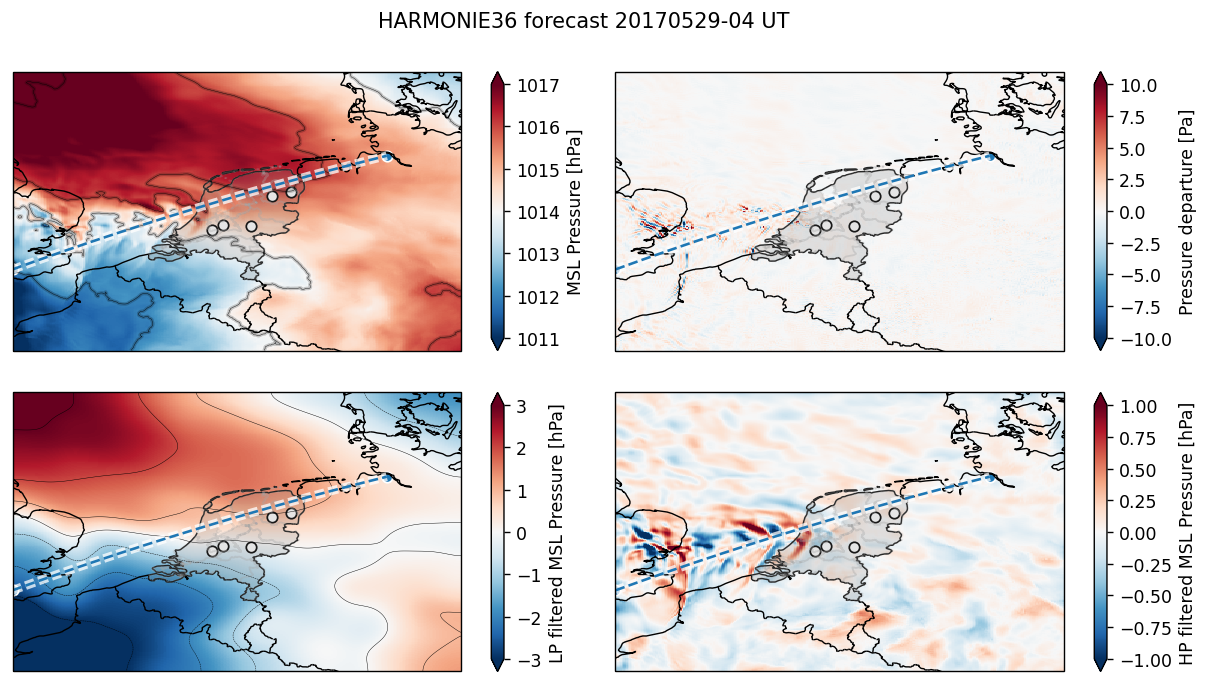

In [18]:
plot_pressure(my_atmos, ds)

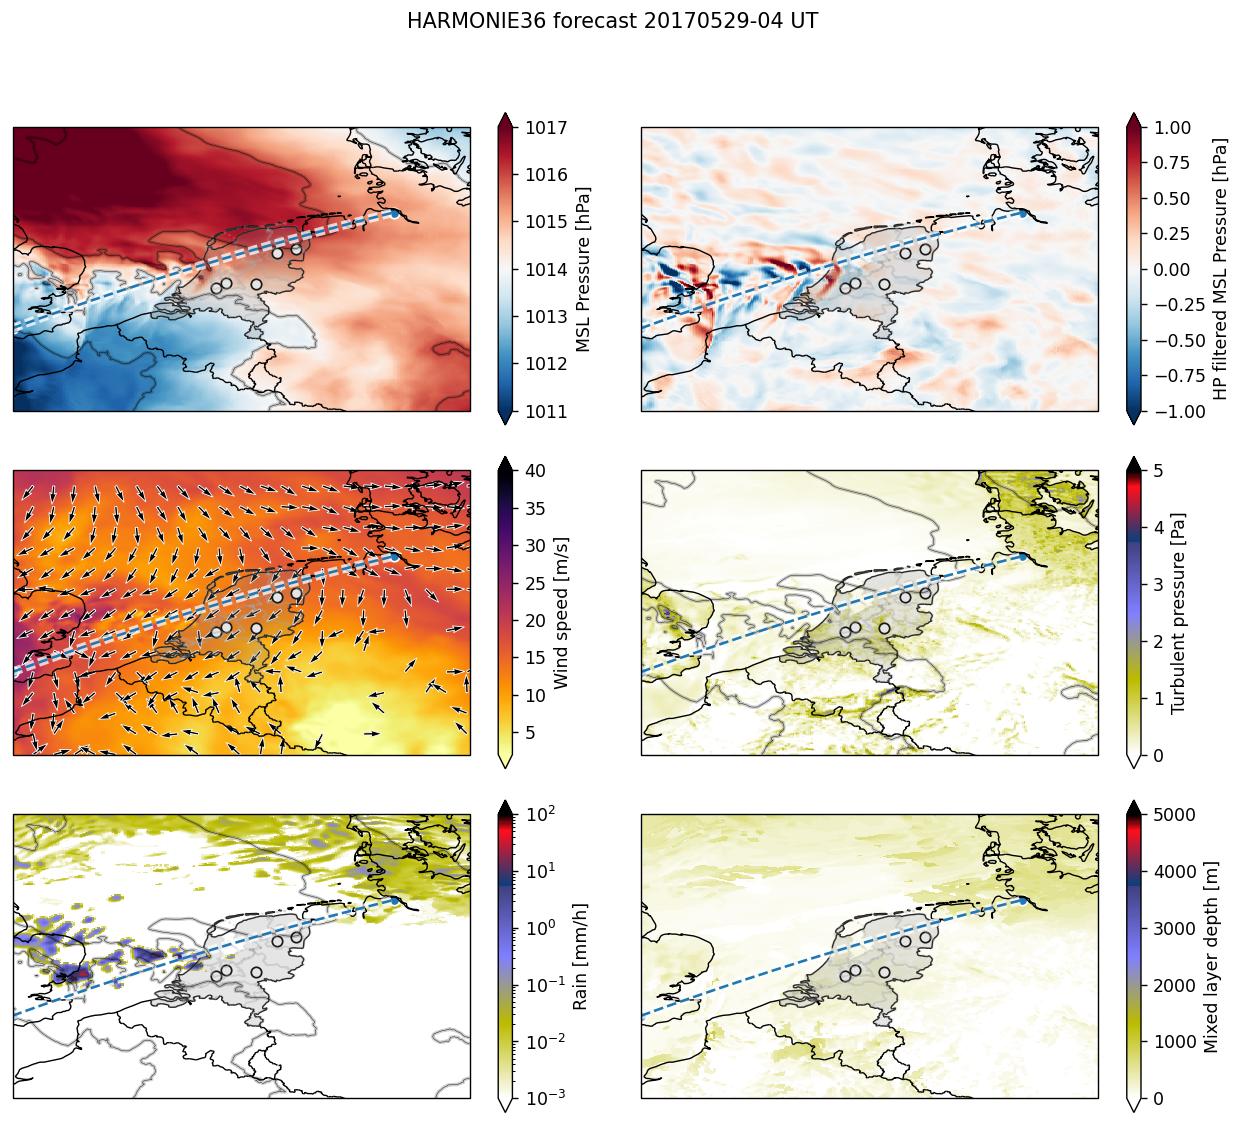

In [19]:
plot_meteo(my_atmos, ds)

## Sample model at locations and write to dataframe

In [20]:
ds_sample = sample_model(ds, df)

In [21]:
ds_sample

<xarray.Dataset>
Dimensions:         (heightAboveGround: 2, hybrid: 60, site_index: 5)
Coordinates:
    time            datetime64[ns] 2017-05-29T03:00:00
    step            timedelta64[ns] 01:00:00
    valid_time      datetime64[ns] 2017-05-29T04:00:00
    heightAboveSea  int64 0
    longitude       (site_index) float64 4.928 5.176 5.887 6.395 6.866
    latitude        (site_index) float64 51.97 52.1 52.06 52.81 52.91
  * site_index      (site_index) int64 0 1 2 3 4
    site_code       (site_index) object 'NL.CIA' 'NL.DBNI' ... 'NL.EXL'
    site_location   (site_index) object 'Cabauw' 'De Bilt' ... 'Exloo'
Dimensions without coordinates: heightAboveGround, hybrid
Data variables:
    u               (hybrid, site_index) float64 -7.934 -8.168 ... -0.5604
    v               (hybrid, site_index) float64 -5.586 -5.621 ... -1.173 -1.471
    pres            (site_index) float64 1.014e+05 1.014e+05 ... 1.016e+05
    ugst            (site_index) float64 -3.772 -4.662 -5.824 -2.04 -0.7343
    vgst            (site_index) float64 -2.247 -2.475 -2.916 -2.156 -2.531
    mld             (site_index) float64 146.9 251.1 194.5 139.3 78.25
    tp              (heightAboveGround, site_index) float64 0.0 0.0 ... 0.0 0.0
    windgust_speed  (site_index) float64 4.392 5.281 6.515 2.984 2.642
    wind_speed      (hybrid, site_index) float64 9.703 9.915 ... 1.689 1.575
    pres_msl        (site_index) float64 1.014e+03 1.014e+03 ... 1.016e+03
    pres_hp         (site_index) float64 -0.1791 -0.188 -0.01719 -0.01308 0.1516
    pres_lp         (site_index) float64 -0.438 -0.2373 -0.1897 0.9078 0.9681
    pres_turb       (site_index) float64 0.2815 0.5428 0.5819 0.2551 0.1884
    tke_ground      (site_index) float64 0.2297 0.4421 0.4776 0.2069 0.1525
    rain            (heightAboveGround, site_index) float64 0.0 0.0 ... 0.0 0.0